# COMPARING CNN ARCHITECTURE USING NIST HANDWRITING DATASET IN IMAGE RECOGNITION

Import all the libraries

In [1]:
# load file
import os

# get directories name
import pathlib

# randomize order (we are using seed too)
import random

# Sort zipper value
from operator import itemgetter

# modify image
import cv2
import imutils

# Use numpy arrays to manipulate (normalize) data
import numpy as np

# Creating graphs & tables
import matplotlib.pylab as plt
import pandas as pd

# Make report and multiclass clasification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# We are using keras tensorflow and use CNN
import tensorflow as tf
from tensorflow import keras

# Import all the keras layers for CNN
from keras.layers.convolutional import Conv2D # to add convolutional layers
from keras.layers.convolutional import MaxPooling2D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers
from keras.layers import Dense # Fully connected layers

# Save models, only save the higher accuracy model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
# Getting boxes around a pattern to trim extra spaces and get similarly size characters
# #default is by using left-to-right text scan
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [5]:
# Make line thinner to show better handwriting features
# Cropping the box around letters
# Resize letter into 64x64 pixels
def crop_letter(img):
    gray = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=20)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    # loop over the contours (boxes around characters)
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)

        # if width or height is unreasonably small
        # skip, might be an incorrect contour
        if w < 15 and h < 15:
            # In case of no contour found, use the original image
            if not 'resized' in locals():
                resized = cv2.resize(gray, (64, 64), interpolation = cv2.INTER_CUBIC)

            continue
            #(x, y, w, h) = 0,0,128,128

        roi = gray[y:y + h, x:x + w]
        ret, thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV)
        resized = cv2.resize(thresh, (64, 64), interpolation = cv2.INTER_CUBIC)

    return resized

In [6]:
# Decode a path filename into the respected Uppercase Character
def getchar(path):
    return bytearray.fromhex(os.path.basename(os.path.dirname(path))).decode()

In [7]:
# Print the 1 Letter
def print_one(image, letter):
    plt.figure(figsize=(10,10))
    plt.subplot(1,1, 1)
    plt.imshow(image, cmap=plt.get_cmap('Greys'))
    plt.axis('off')
    plt.title("Letter: " + letter)
    plt.show()

In [8]:
# Print the first 25 letters
def print_top(images, labels, is_last=False):
    if len(images) != len(labels):
        print("Length data ", len(images), " is different with length of label: ", len(labels))

    start_range = 0
    end_range = 25

    if is_last:
        start_range = len(images)-25
        end_range = len(images)

    plt.figure(figsize=(10,10))

    for i in range(start_range, end_range):
        plt.subplot(5,5, i+1-start_range)
        plt.imshow(images[i], cmap=plt.get_cmap('Greys'))
        plt.axis('off')
        plt.title("Letter: " + labels[i])
    plt.show()

In [9]:
# Return data of index, predicted_letter, probability, second_prediction
def sort_prediction(predicts):
    indexes = []
    first_prediction = []
    first_probability = []
    second_prediction = []
    second_probability = []

    # Get prediction sorted and return arrays
    for i, pred in enumerate(predicts):
        # indexnya ada di mana
        letter_sorted, pred = zip(*sorted(zip(letters, pred),
                                          key=itemgetter(1), reverse=True))
        indexes.append(i)
        first_prediction.append(letter_sorted[0])
        first_probability.append(pred[0])
        second_prediction.append(letter_sorted[1])
        second_probability.append(pred[1])

    # Return prediction sorted from the lowest
    # value: indexes, prediction, probability, second_prediction, second_probability
    return zip(*sorted(zip(indexes, first_prediction, first_probability,
                           second_prediction, second_probability),
                       key=itemgetter(2), reverse=False))

In [10]:
# Print the history and model summary
def show_history(hist):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [11]:
# Print the first 25 Prediction
def print_prediction(first_prediction, first_probability, second_prediction, second_probability, is_last=False):
    if (len(first_prediction) != len(first_probability) or
            len(first_prediction) != len(second_prediction) or
            len(second_prediction) != len(second_probability)):
        print("Length data is different")

    start_range = 0
    end_range = 25

    if is_last:
        start_range = len(first_prediction)-25
        end_range = len(first_prediction)

    for i in range(start_range, end_range):
        print("Index: ", i, " Prediction: ", first_prediction[i], "(",
              first_probability[i],") - ", second_prediction[i], "(",
              second_probability[i],")")

In [12]:
# Load data from NIST upper directory and randomize the order

# Local folder name
handwriting_dir = "/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/"

# Get path
data_dir = pathlib.Path(handwriting_dir)

# List all png within upper directory & randomize it
all_handwriting = list(data_dir.rglob('*/upper/*/*.png'))
handwriting_path = [str(path) for path in all_handwriting]
random.seed(1337)
tf.random.set_seed(1337)
random.shuffle(handwriting_path)

# Print the data size
data_size=len(all_handwriting)
data_size

81463

In [13]:
# Check the first 10 file path that has been randomized
handwriting_path[:10]

['/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_7/upper/47/47_00210.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_4/upper/54/54_00424.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_3/upper/49/49_00248.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_4/upper/59/59_00154.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_3/upper/4c/4C_00069.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_1/upper/5a/5A_00151.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_7/upper/49/49_00189.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_4/upper/4e/4E_00035.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/handwriting/by_field/hsf_2/upper/57/57_00204.png',
 '/Users/Mac/Documents/Kuliah Master/Machine Learning/h

In [14]:
# Hex value (from a letter) of the first handwriting path
os.path.basename(os.path.dirname(handwriting_path[0]))

'47'

In [15]:
# Standardize input data size:
# - Dilate the picture
# - Crop the extra spaces
# - Resize data into 64x64
# - Zero centered average normalization

# Channel are black and white
IMG_SIZE=64

X_data = np.ndarray(shape=(len(handwriting_path), IMG_SIZE, IMG_SIZE),
                     dtype=np.uint8)

y = np.array([getchar(handwriting) for handwriting in handwriting_path], )

# Loop directories only for upper fields
i = 0
for _handwriting in handwriting_path:
    X_data[i] = crop_letter(_handwriting)
    i += 1

print("Total Upper Characters:\n ", len(X_data))

Total Upper Characters:
  81463


In [16]:
X_data[2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

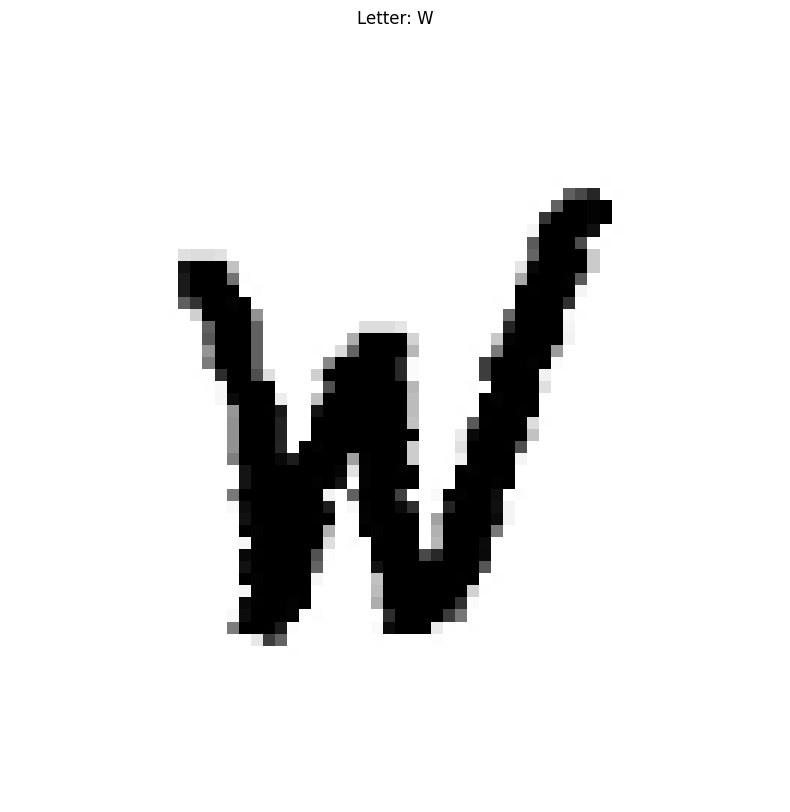

In [17]:
print_one(X_data[8], y[8])

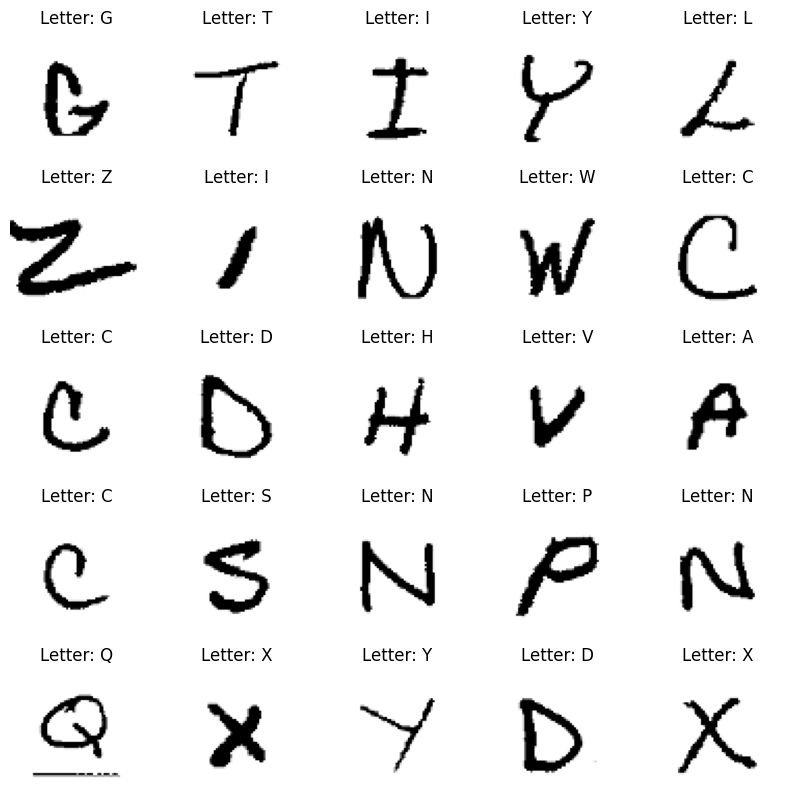

In [18]:
# Print handwriting data
print_top(X_data, y)

In [19]:
# get mean and standard deviation for zero centering normalization
mean = X_data.mean()
std = X_data.std()
print(mean, std)

23.590328689649557 71.5706285034013


In [20]:
# Zero centering
X = X_data - mean

# show min after zero centering
X.min(), X.max()

(-23.590328689649557, 231.40967131035043)

In [21]:
# Normalization
# We multiply because it is faster than division
inv_std = 1/std
X *= inv_std

X.min(),X.max()

(-0.3296090754397729, 3.233305004431434)

In [22]:
# Split data 15% for Testing : 85% for Training
train_test_split = (int)(data_size*0.15)

X_train=X[train_test_split:]
X_test=X[:train_test_split]

X_original_test=X_data[:train_test_split]
y_original_test = y[:train_test_split]

y_train_char = y[train_test_split:]
y_test_char = y[:train_test_split]



In [23]:
X_test[0]

array([[-0.32960908, -0.32960908, -0.32960908, ..., -0.32960908,
        -0.32960908, -0.32960908],
       [-0.32960908, -0.32960908, -0.32960908, ..., -0.32960908,
        -0.32960908, -0.32960908],
       [-0.32960908, -0.32960908, -0.32960908, ..., -0.32960908,
        -0.32960908, -0.32960908],
       ...,
       [-0.32960908, -0.32960908, -0.32960908, ..., -0.32960908,
        -0.32960908, -0.32960908],
       [-0.32960908, -0.32960908, -0.32960908, ..., -0.32960908,
        -0.32960908, -0.32960908],
       [-0.32960908, -0.32960908, -0.32960908, ..., -0.32960908,
        -0.32960908, -0.32960908]])

In [24]:
# Encode category for the y and print the total category
letters = np.unique(y)
no_letters = len(letters)

label_encoder = LabelEncoder()
y_train_vec = label_encoder.fit_transform(y_train_char)
y_test_vec = label_encoder.fit_transform(y_test_char)

y_train = keras.utils.to_categorical(y_train_vec)
y_test = keras.utils.to_categorical(y_test_vec)

num_classes = y_test.shape[1] # number of categories
print("Total Training: ", len(X_train))
print("Total Test: ", len(X_test))

print("Total Unique Value of y: ", no_letters)

Total Training:  69244
Total Test:  12219
Total Unique Value of y:  26


In [25]:
letters

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype='<U1')

In [26]:
# Print number of each letters
print('Training')
for letter in letters:
    count = np.count_nonzero(y_train_char == letter)
    print('number of letter ', letter, ': ', count)


print('Testing')
for letter in letters:
    count = np.count_nonzero(y_test_char == letter)
    print('number of letter ', letter, ': ', count)


Training
number of letter  A :  2569
number of letter  B :  2556
number of letter  C :  2824
number of letter  D :  2541
number of letter  E :  2487
number of letter  F :  2608
number of letter  G :  2519
number of letter  H :  2541
number of letter  I :  3826
number of letter  J :  2481
number of letter  K :  2391
number of letter  L :  2854
number of letter  M :  2606
number of letter  N :  2639
number of letter  O :  2698
number of letter  P :  2652
number of letter  Q :  2599
number of letter  R :  2598
number of letter  S :  2650
number of letter  T :  2576
number of letter  U :  2676
number of letter  V :  2766
number of letter  W :  2634
number of letter  X :  2720
number of letter  Y :  2543
number of letter  Z :  2690
Testing
number of letter  A :  464
number of letter  B :  470
number of letter  C :  520
number of letter  D :  479
number of letter  E :  405
number of letter  F :  445
number of letter  G :  445
number of letter  H :  384
number of letter  I :  664
number of le

In [27]:
# Return data of index, predicted_letter, probability, second_prediction
def xy_sort(indexes, X_val=X_original_test, y_val=y_original_test):
    X_sort = X_val.copy()
    y_sort = y_val.copy()

    # Sort
    count = 0
    for i in indexes:
        X_sort[count] = X_val[i]
        y_sort[count] = y_val[i]
        count += 1

    return X_sort, y_sort

In [28]:
def evaluate_and_predict(model, X_eval=X_test, y_eval=y_test):
    # Evaluate the model Accuracy
    scores = model.evaluate(x=X_eval, y=y_eval, verbose=1)
    print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

    predictions = model.predict(X_eval)
    max_y_pred = np.argmax(predictions, axis=1)
    max_y_test = np.argmax(y_eval, axis=1)

    # Plot confusion_matrix
    cmatrix= confusion_matrix(max_y_test, max_y_pred)

    # Print Classification Report
    max_y_pred = np.argmax(predictions, axis=1)
    max_y_test = np.argmax(y_eval, axis=1)
    print(classification_report(max_y_test, max_y_pred))

    return predictions, cmatrix

In [29]:
def get_checkpoint(filename="model"):
    checkpoint = ModelCheckpoint(filename + ".h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

    return checkpoint, early

In [30]:
# Starting model for all predictor with 2 conv layer and 1 pooling layer in the middle
def get_starting_model():
    # create first part of the model
    model = tf.keras.Sequential()

    model.add(Conv2D(input_shape=(64,64,1), filters=64,kernel_size=(3,3),padding="same", activation="relu"))

    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

    return model


In [31]:
# Create model with SGD optimizer
def sgd_optimizer():
    model = get_starting_model()

    # Third Conv Layer and second pooling
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(units=512,activation="relu"))
    model.add(Dense(no_letters, activation='softmax'))

    # compile model
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
def convolutional_model1():
    # create model
    model = get_starting_model()

    # add 1 pooling layer
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())

    # 2 Fully Connected Layer
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(no_letters, activation='softmax'))

    # Compile Model with Adam optimizer
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
def convolutional_model2():
    # create model
    model = get_starting_model()

    # add 1 convolution layer and 1 pooling layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())

    # 2 Fully Connected Layer
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(no_letters, activation='softmax'))

    # Compile Model with Adam optimizer
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [34]:
def convolutional_model3():
    # create starting model with 2 conv and 1 pooling
    model = get_starting_model()

    # add 1 convolution layer and 1 pooling layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())

    # 2 Fully Connected Layer with different parameter with the second conv model
    model.add(Dense(units=512,activation="relu"))
    model.add(Dense(no_letters, activation='softmax'))

    # Compile Model with Adam optimizer
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [35]:
# Checkpoint and early stopping parameter
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
cp_conv1 = get_checkpoint("cp1")

# Build the model
conv1 = convolutional_model1()

# Fit the model
history = conv1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,
                        batch_size=100, callbacks=[cp_conv1, early], verbose=2)

Metal device set to: Apple M1


2022-09-03 10:23:00.335506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-03 10:23:00.336876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2022-09-03 10:23:04.089760: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-03 10:23:04.888073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:24:03.156499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.95622, saving model to cp1.h5
693/693 - 62s - loss: 0.3426 - accuracy: 0.9058 - val_loss: 0.1553 - val_accuracy: 0.9562 - 62s/epoch - 90ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.95622 to 0.95982, saving model to cp1.h5
693/693 - 60s - loss: 0.1095 - accuracy: 0.9681 - val_loss: 0.1406 - val_accuracy: 0.9598 - 60s/epoch - 87ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.95982
693/693 - 60s - loss: 0.0673 - accuracy: 0.9793 - val_loss: 0.1487 - val_accuracy: 0.9576 - 60s/epoch - 86ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.95982 to 0.96530, saving model to cp1.h5
693/693 - 59s - loss: 0.0474 - accuracy: 0.9852 - val_loss: 0.1357 - val_accuracy: 0.9653 - 59s/epoch - 86ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.96530
693/693 - 59s - loss: 0.0309 - accuracy: 0.9899 - val_loss: 0.1564 - val_accuracy: 0.9633 - 59s/epoch - 86ms/step
Epoch 6/10

Epoch 6: val_accuracy did not imp

In [36]:
conv1_predict, cmatrix_c1 = evaluate_and_predict(conv1)


382/382 [==============================] - 5s 12ms/step - loss: 0.2103 - accuracy: 0.9628
Accuracy: 0.9628447890281677 
 Error: 3.7155210971832275
 17/382 [>.............................] - ETA: 3s

2022-09-03 10:33:07.414738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       464
           1       0.99      0.97      0.98       470
           2       0.96      0.98      0.97       520
           3       0.97      0.89      0.93       479
           4       0.99      0.97      0.98       405
           5       0.97      0.99      0.98       445
           6       0.97      0.98      0.97       445
           7       0.97      0.95      0.96       384
           8       0.97      0.96      0.97       664
           9       0.95      0.97      0.96       477
          10       0.97      0.94      0.95       459
          11       0.97      0.97      0.97       521
          12       0.97      0.98      0.97       471
          13       0.95      0.98      0.97       489
          14       0.90      0.98      0.94       478
          15       0.99      0.97      0.98       475
          16       0.97  

In [37]:
df_c1 = pd.DataFrame(cmatrix_c1, index=letters, columns=letters)
df_c1.style.background_gradient(cmap="hot_r")

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,455,0,0,0,0,0,0,6,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0
B,2,455,0,0,0,1,0,1,0,1,0,0,0,0,2,0,1,5,0,0,0,0,0,0,0,2
C,0,0,511,0,0,0,1,0,0,0,0,6,0,0,2,0,0,0,0,0,0,0,0,0,0,0
D,0,3,0,428,0,0,0,0,2,2,0,1,1,0,38,0,1,0,0,0,3,0,0,0,0,0
E,0,0,6,0,392,3,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
F,1,0,0,0,1,439,1,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
G,0,0,5,0,0,0,437,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0
H,1,0,0,0,0,0,0,365,1,0,2,1,5,6,0,0,0,0,0,0,2,1,0,0,0,0
I,0,0,1,0,0,1,1,0,640,9,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,8
J,0,0,0,1,0,1,2,0,3,463,0,0,0,0,0,0,0,0,3,1,0,3,0,0,0,0


In [38]:
# Make prediction and sort
indexes, first_prediction, first_probability, second_prediction, second_probability = sort_prediction(conv1_predict)
X_sort, y_sort = xy_sort(indexes)
#first_prediction[0]
#indexes[0]
#X[6844]
#y[6844]

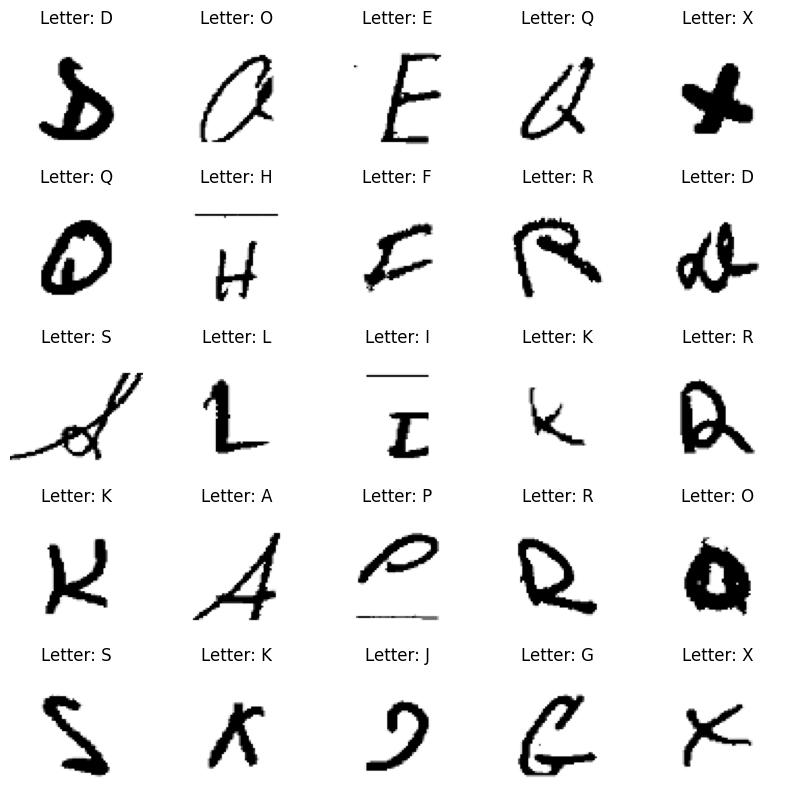

In [39]:
# Print top lowest percentage
print_top(X_sort, y_sort)

In [40]:
print_prediction(first_prediction, first_probability, second_prediction, second_probability)

Index:  0  Prediction:  D ( 0.31408966 ) -  I ( 0.3080625 )
Index:  1  Prediction:  G ( 0.34507987 ) -  A ( 0.289881 )
Index:  2  Prediction:  F ( 0.35531232 ) -  G ( 0.34410113 )
Index:  3  Prediction:  Q ( 0.3737676 ) -  L ( 0.2823467 )
Index:  4  Prediction:  F ( 0.38769844 ) -  X ( 0.29709843 )
Index:  5  Prediction:  Q ( 0.4053688 ) -  O ( 0.3770386 )
Index:  6  Prediction:  V ( 0.40799958 ) -  U ( 0.3058054 )
Index:  7  Prediction:  E ( 0.41182673 ) -  G ( 0.3949843 )
Index:  8  Prediction:  R ( 0.41613543 ) -  B ( 0.4068144 )
Index:  9  Prediction:  M ( 0.42821792 ) -  G ( 0.38818717 )
Index:  10  Prediction:  L ( 0.4308957 ) -  H ( 0.23287545 )
Index:  11  Prediction:  C ( 0.4375798 ) -  I ( 0.32228744 )
Index:  12  Prediction:  G ( 0.4489211 ) -  I ( 0.40119976 )
Index:  13  Prediction:  K ( 0.4499408 ) -  L ( 0.37318817 )
Index:  14  Prediction:  A ( 0.45208704 ) -  N ( 0.18203415 )
Index:  15  Prediction:  K ( 0.45257667 ) -  X ( 0.4503709 )
Index:  16  Prediction:  A ( 0.45

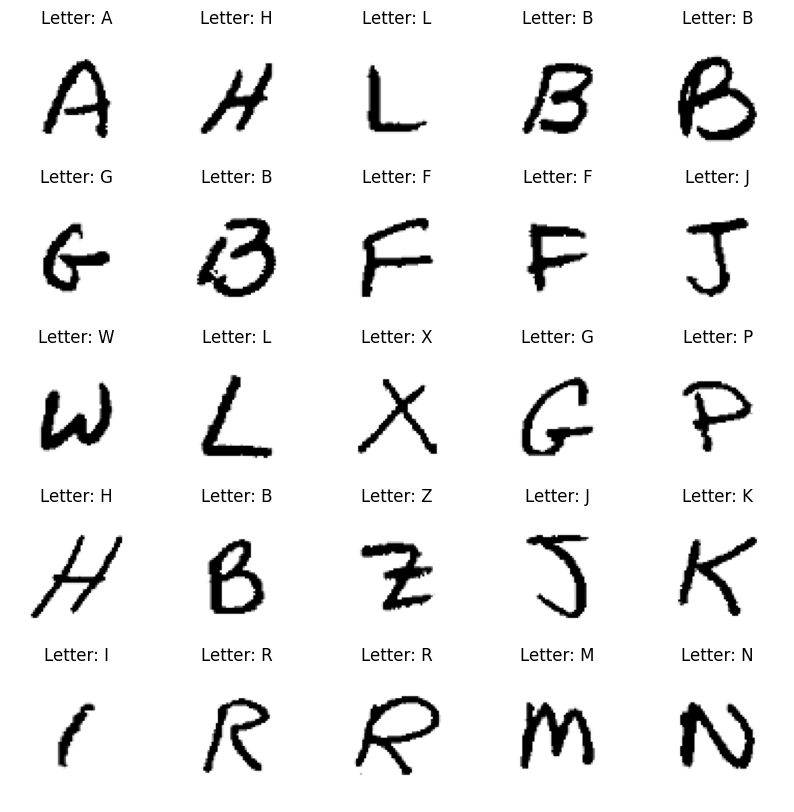

In [41]:
# Print top
print_top(X_sort, y_sort, is_last=True)

In [42]:
print_prediction(first_prediction, first_probability, second_prediction, second_probability, is_last=True)

Index:  12194  Prediction:  A ( 1.0 ) -  H ( 3.0178516e-12 )
Index:  12195  Prediction:  H ( 1.0 ) -  A ( 1.9157618e-09 )
Index:  12196  Prediction:  L ( 1.0 ) -  C ( 1.7500595e-08 )
Index:  12197  Prediction:  B ( 1.0 ) -  R ( 3.823048e-09 )
Index:  12198  Prediction:  B ( 1.0 ) -  A ( 2.7466127e-08 )
Index:  12199  Prediction:  G ( 1.0 ) -  F ( 1.5580324e-09 )
Index:  12200  Prediction:  B ( 1.0 ) -  D ( 1.110409e-09 )
Index:  12201  Prediction:  F ( 1.0 ) -  E ( 1.0299774e-11 )
Index:  12202  Prediction:  F ( 1.0 ) -  E ( 3.731476e-09 )
Index:  12203  Prediction:  J ( 1.0 ) -  S ( 1.0445503e-09 )
Index:  12204  Prediction:  W ( 1.0 ) -  U ( 2.2483217e-08 )
Index:  12205  Prediction:  L ( 1.0 ) -  K ( 2.6125808e-09 )
Index:  12206  Prediction:  X ( 1.0 ) -  R ( 3.5127423e-09 )
Index:  12207  Prediction:  G ( 1.0 ) -  C ( 3.3530775e-08 )
Index:  12208  Prediction:  P ( 1.0 ) -  O ( 1.819855e-10 )
Index:  12209  Prediction:  H ( 1.0 ) -  K ( 7.928048e-10 )
Index:  12210  Prediction:  B

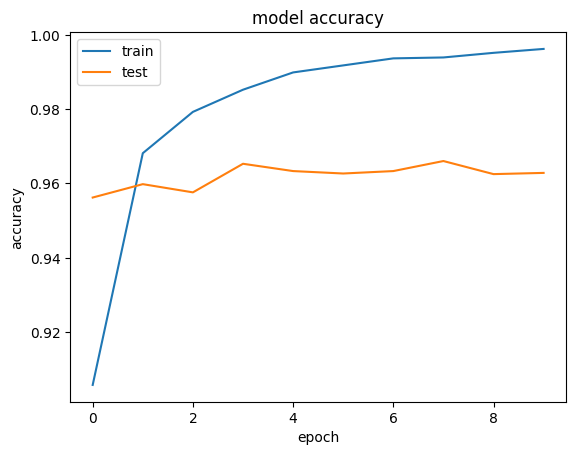

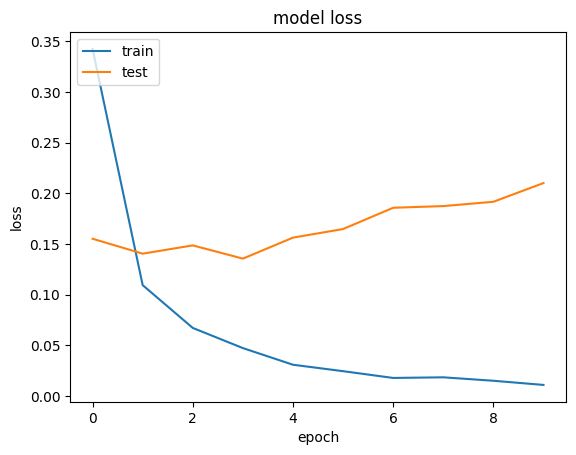

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [43]:
show_history(history)
conv1.summary()

In [44]:
# build the model
cp_conv2 = get_checkpoint("cp2")
conv2 = convolutional_model2()

# fit the model
history = conv2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, callbacks=[cp_conv2, early], verbose=2)

Epoch 1/10


2022-09-03 10:33:22.288260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:34:53.877917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.96113, saving model to cp2.h5
693/693 - 97s - loss: 0.2793 - accuracy: 0.9212 - val_loss: 0.1394 - val_accuracy: 0.9611 - 97s/epoch - 141ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.96113 to 0.97005, saving model to cp2.h5
693/693 - 94s - loss: 0.0959 - accuracy: 0.9723 - val_loss: 0.1052 - val_accuracy: 0.9700 - 94s/epoch - 136ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.97005
693/693 - 95s - loss: 0.0597 - accuracy: 0.9821 - val_loss: 0.1152 - val_accuracy: 0.9690 - 95s/epoch - 137ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.97005
693/693 - 94s - loss: 0.0414 - accuracy: 0.9870 - val_loss: 0.1193 - val_accuracy: 0.9690 - 94s/epoch - 136ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.97005 to 0.97021, saving model to cp2.h5
693/693 - 96s - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.1161 - val_accuracy: 0.9702 - 96s/epoch - 138ms/step
Epoch 6/10

Epoch 6: val_accuracy did no

382/382 [==============================] - 6s 17ms/step - loss: 0.1838 - accuracy: 0.9688
Accuracy: 0.9688190817832947 
 Error: 3.1180918216705322
  9/382 [..............................] - ETA: 5s

2022-09-03 10:49:21.437805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 6s 17ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       464
           1       0.99      0.98      0.98       470
           2       0.98      0.97      0.98       520
           3       0.94      0.96      0.95       479
           4       0.99      0.98      0.99       405
           5       0.97      0.98      0.98       445
           6       0.96      0.98      0.97       445
           7       0.99      0.97      0.98       384
           8       0.95      0.99      0.97       664
           9       0.98      0.94      0.96       477
          10       0.97      0.97      0.97       459
          11       0.98      0.96      0.97       521
          12       0.96      0.99      0.98       471
          13       0.99      0.93      0.96       489
          14       0.98      0.93      0.96       478
          15       0.99      0.99      0.99       475
          16       0.94  

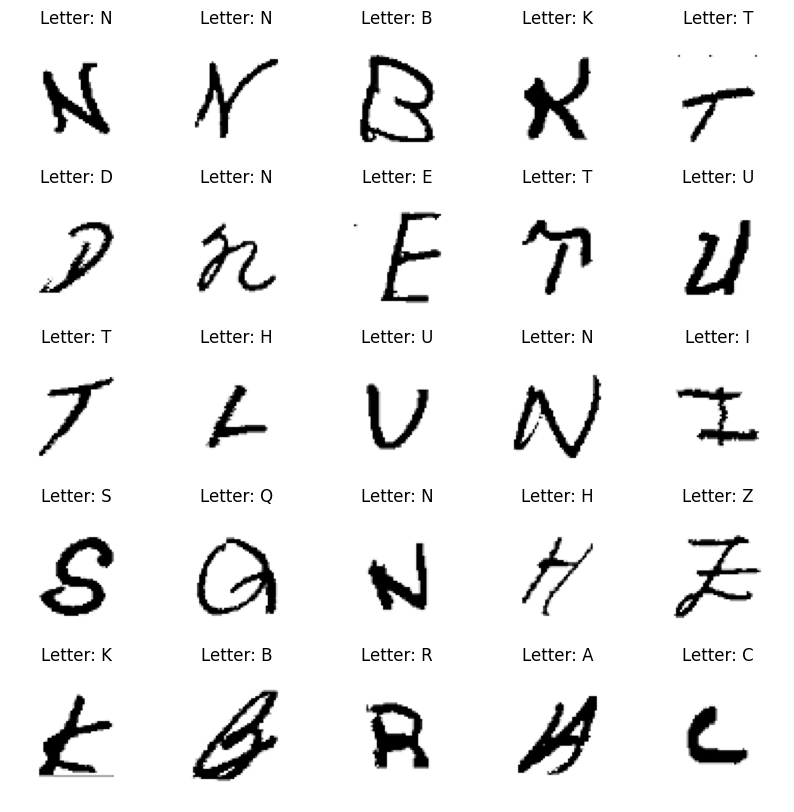

Index:  0  Prediction:  H ( 0.41302156 ) -  K ( 0.34719387 )
Index:  1  Prediction:  V ( 0.41485533 ) -  N ( 0.25572634 )
Index:  2  Prediction:  R ( 0.42079407 ) -  D ( 0.27197748 )
Index:  3  Prediction:  K ( 0.45626742 ) -  X ( 0.2541725 )
Index:  4  Prediction:  F ( 0.46414065 ) -  H ( 0.3288431 )
Index:  5  Prediction:  P ( 0.47592607 ) -  D ( 0.46676487 )
Index:  6  Prediction:  X ( 0.47946674 ) -  U ( 0.38741067 )
Index:  7  Prediction:  I ( 0.48089305 ) -  G ( 0.40135425 )
Index:  8  Prediction:  D ( 0.4814255 ) -  P ( 0.45057368 )
Index:  9  Prediction:  U ( 0.4972669 ) -  N ( 0.4537846 )
Index:  10  Prediction:  T ( 0.49779657 ) -  X ( 0.35106322 )
Index:  11  Prediction:  F ( 0.49881905 ) -  L ( 0.4958703 )
Index:  12  Prediction:  U ( 0.49997038 ) -  V ( 0.4998564 )
Index:  13  Prediction:  W ( 0.50220585 ) -  N ( 0.49779415 )
Index:  14  Prediction:  Z ( 0.5029664 ) -  I ( 0.49669722 )
Index:  15  Prediction:  S ( 0.5032354 ) -  G ( 0.4967515 )
Index:  16  Prediction:  Q (

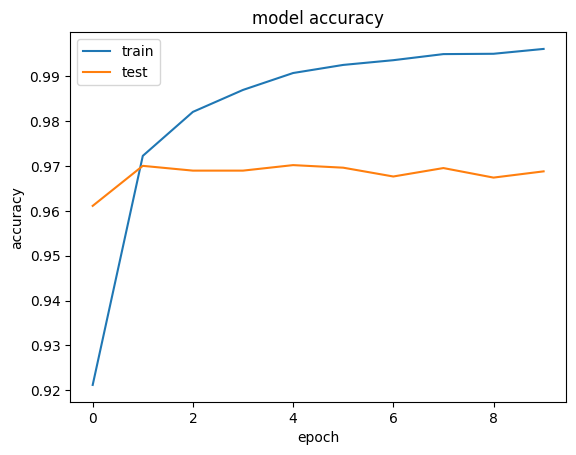

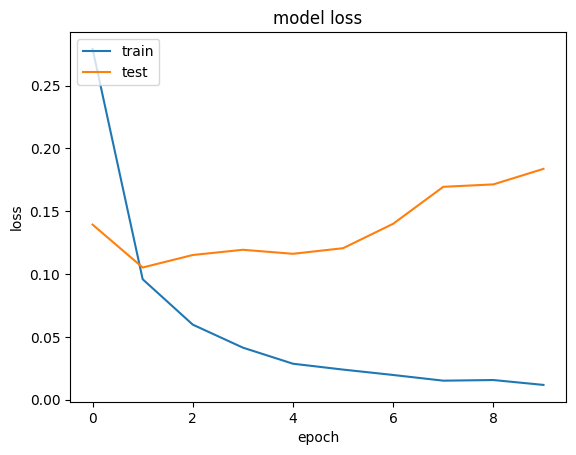

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)            

In [45]:
# Make prediction and sort
conv2_predict, cmatrix_c2 = evaluate_and_predict(conv2)
indexes, first_prediction, first_probability, second_prediction, second_probability = sort_prediction(conv2_predict)
X_sort, y_sort = xy_sort(indexes)

# Print information
print_top(X_sort, y_sort)
print_prediction(first_prediction, first_probability, second_prediction, second_probability)
show_history(history)
conv2.summary()

In [46]:
df_c2 = pd.DataFrame(cmatrix_c2, index=letters, columns=letters)
df_c2.style.background_gradient(cmap="hot_r")

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,459,1,0,0,0,0,0,2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
B,0,460,0,1,0,0,2,0,0,0,0,0,0,0,0,0,2,3,2,0,0,0,0,0,0,0
C,0,0,507,0,0,0,4,0,1,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,2,0,462,0,0,1,0,1,1,0,0,0,0,7,3,1,0,0,0,1,0,0,0,0,0
E,0,0,1,0,397,1,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
F,0,0,0,0,1,438,1,0,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0
G,1,0,6,0,1,0,435,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
H,2,0,0,0,0,1,1,373,1,0,0,0,2,0,0,0,1,0,0,0,2,0,0,1,0,0
I,0,0,0,0,1,1,0,0,655,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1
J,0,0,0,1,0,0,2,0,9,447,0,0,0,0,0,0,0,0,15,1,2,0,0,0,0,0


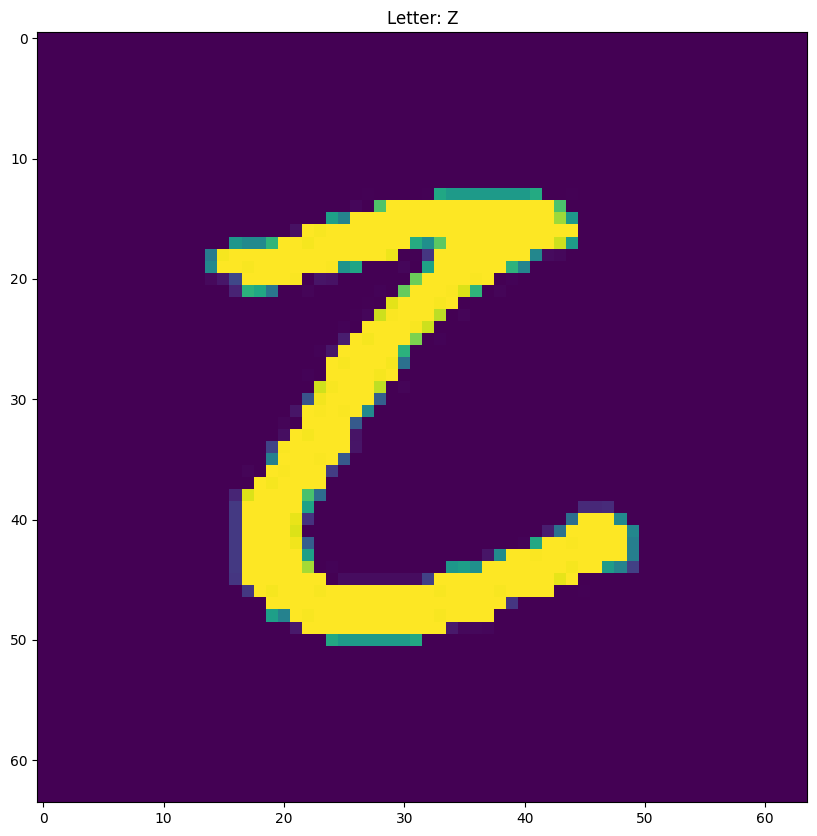

(9346, 'F', 0.49881905, 'L', 0.4958703)

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(1,1, 1)
plt.imshow(X[11248])
plt.title("Letter: " + y[11248])
plt.show()

indexes[11], first_prediction[11], first_probability[11], second_prediction[11], second_probability[11]
#len( index )
#index
#y[4046]
#handwriting_path[30]

In [48]:
# build the model
cp_conv3 = get_checkpoint("cp3")
conv3 = convolutional_model3()

# fit the model
history = conv3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, callbacks=[cp_conv2, early], verbose=2)

Epoch 1/10


2022-09-03 10:49:37.516006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:51:20.115622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy did not improve from 0.97021
693/693 - 108s - loss: 0.2730 - accuracy: 0.9239 - val_loss: 0.1229 - val_accuracy: 0.9633 - 108s/epoch - 156ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.97021
693/693 - 107s - loss: 0.0851 - accuracy: 0.9745 - val_loss: 0.1073 - val_accuracy: 0.9687 - 107s/epoch - 154ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.97021
693/693 - 109s - loss: 0.0516 - accuracy: 0.9840 - val_loss: 0.1522 - val_accuracy: 0.9593 - 109s/epoch - 157ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.97021 to 0.97242, saving model to cp2.h5
693/693 - 106s - loss: 0.0358 - accuracy: 0.9884 - val_loss: 0.1061 - val_accuracy: 0.9724 - 106s/epoch - 153ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.97242 to 0.97610, saving model to cp2.h5
693/693 - 106s - loss: 0.0245 - accuracy: 0.9924 - val_loss: 0.1126 - val_accuracy: 0.9761 - 106s/epoch - 154ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 

382/382 [==============================] - 7s 18ms/step - loss: 0.1729 - accuracy: 0.9727
Accuracy: 0.972665548324585 
 Error: 2.733445167541504
  9/382 [..............................] - ETA: 5s

2022-09-03 11:07:31.761462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 7s 18ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       464
           1       0.99      0.97      0.98       470
           2       0.99      0.99      0.99       520
           3       0.95      0.94      0.95       479
           4       0.99      0.98      0.98       405
           5       0.96      1.00      0.98       445
           6       0.97      0.99      0.98       445
           7       0.98      0.97      0.97       384
           8       0.96      0.98      0.97       664
           9       0.96      0.97      0.96       477
          10       0.98      0.96      0.97       459
          11       0.98      0.98      0.98       521
          12       0.98      0.99      0.98       471
          13       0.97      0.98      0.97       489
          14       0.96      0.96      0.96       478
          15       0.99      0.99      0.99       475
          16       0.97  

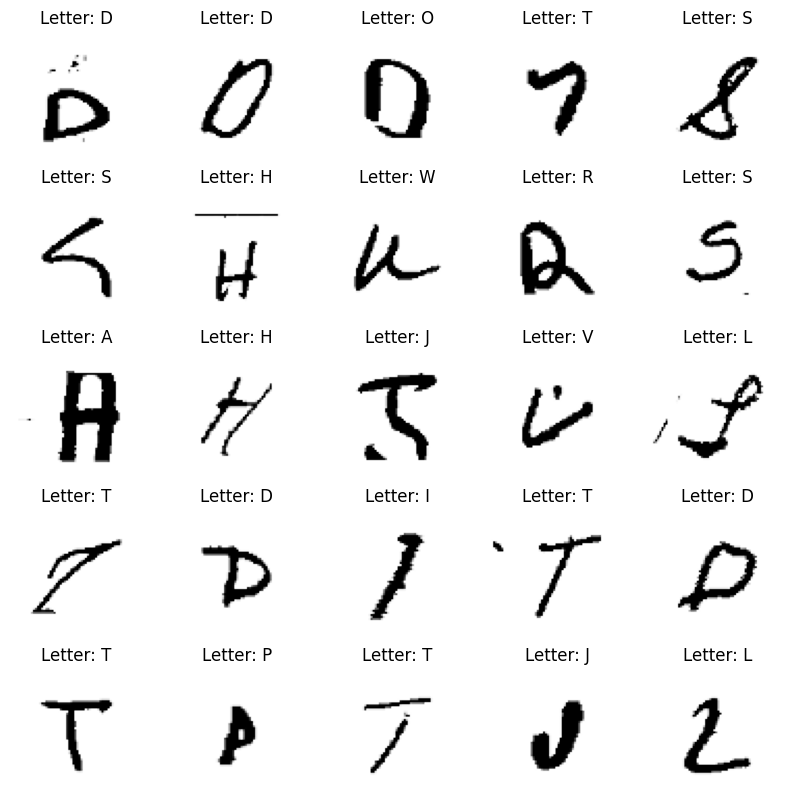

Index:  0  Prediction:  D ( 0.29813626 ) -  B ( 0.29636773 )
Index:  1  Prediction:  U ( 0.34956264 ) -  O ( 0.31735396 )
Index:  2  Prediction:  O ( 0.38371947 ) -  D ( 0.33803496 )
Index:  3  Prediction:  Y ( 0.38612568 ) -  T ( 0.2912976 )
Index:  4  Prediction:  X ( 0.4218857 ) -  L ( 0.35913685 )
Index:  5  Prediction:  S ( 0.42611778 ) -  Z ( 0.29101804 )
Index:  6  Prediction:  N ( 0.438833 ) -  W ( 0.40122414 )
Index:  7  Prediction:  U ( 0.43969008 ) -  X ( 0.32977983 )
Index:  8  Prediction:  Q ( 0.46281984 ) -  A ( 0.33841413 )
Index:  9  Prediction:  Q ( 0.48229754 ) -  S ( 0.40674612 )
Index:  10  Prediction:  G ( 0.4824484 ) -  F ( 0.3682127 )
Index:  11  Prediction:  N ( 0.48350364 ) -  H ( 0.26288727 )
Index:  12  Prediction:  F ( 0.5012232 ) -  I ( 0.49405846 )
Index:  13  Prediction:  U ( 0.50199944 ) -  V ( 0.4979437 )
Index:  14  Prediction:  S ( 0.5024693 ) -  I ( 0.32026717 )
Index:  15  Prediction:  T ( 0.5026062 ) -  F ( 0.31778157 )
Index:  16  Prediction:  P (

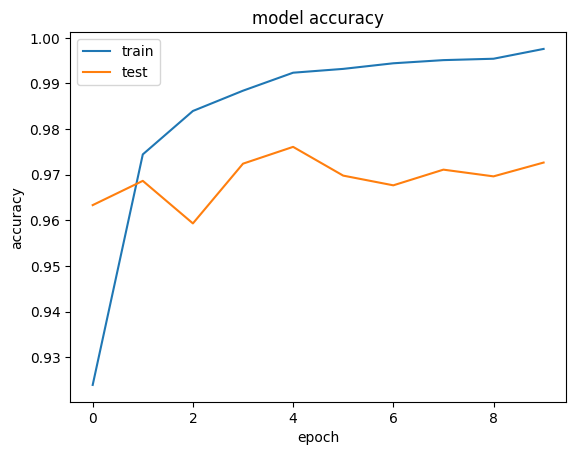

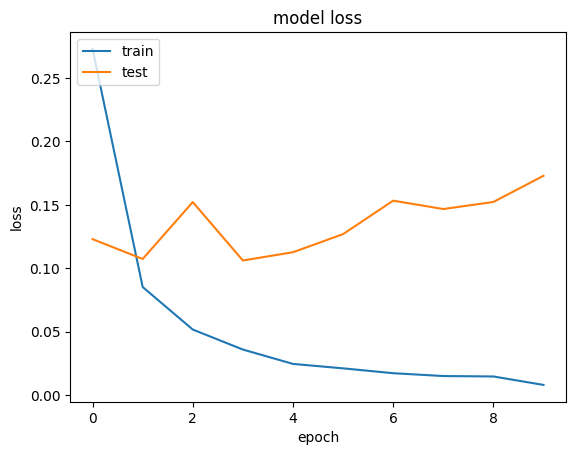

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)            

In [49]:
# Make prediction and sort
conv3_predict, cmatrix_c3 = evaluate_and_predict(conv3)
indexes, first_prediction, first_probability, second_prediction, second_probability = sort_prediction(conv3_predict)
X_sort, y_sort = xy_sort(indexes)

# Print information
print_top(X_sort, y_sort)
print_prediction(first_prediction, first_probability, second_prediction, second_probability)
show_history(history)
conv3.summary()

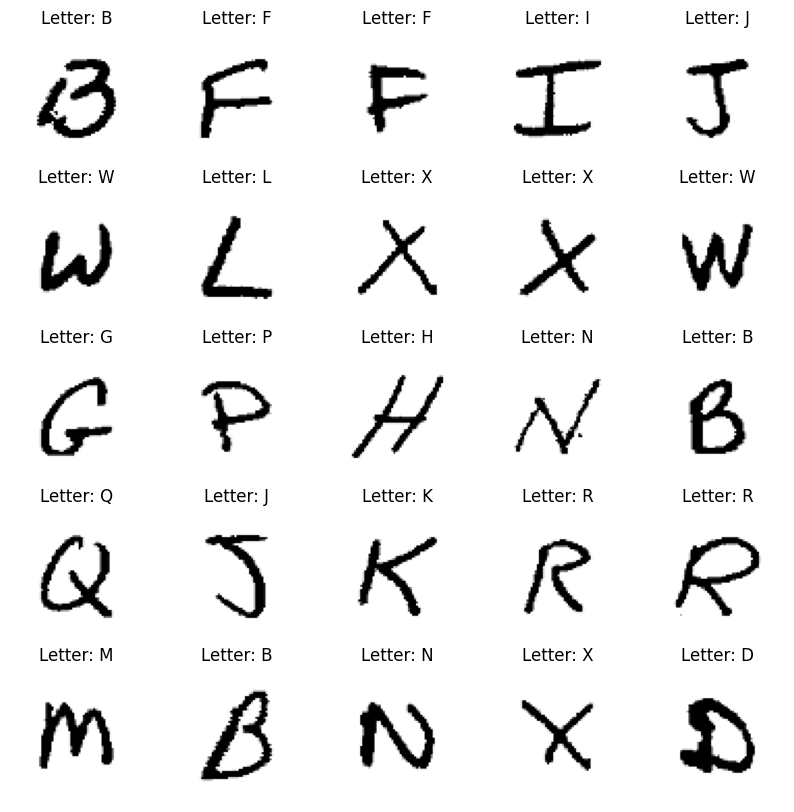

Index:  12194  Prediction:  B ( 1.0 ) -  D ( 5.006543e-08 )
Index:  12195  Prediction:  F ( 1.0 ) -  P ( 1.3422264e-13 )
Index:  12196  Prediction:  F ( 1.0 ) -  P ( 1.7455398e-09 )
Index:  12197  Prediction:  I ( 1.0 ) -  J ( 8.085461e-11 )
Index:  12198  Prediction:  J ( 1.0 ) -  I ( 4.9538373e-09 )
Index:  12199  Prediction:  W ( 1.0 ) -  V ( 6.410258e-12 )
Index:  12200  Prediction:  L ( 1.0 ) -  D ( 1.2114861e-11 )
Index:  12201  Prediction:  X ( 1.0 ) -  M ( 1.9363798e-08 )
Index:  12202  Prediction:  X ( 1.0 ) -  V ( 1.5709888e-09 )
Index:  12203  Prediction:  W ( 1.0 ) -  N ( 5.0031897e-13 )
Index:  12204  Prediction:  G ( 1.0 ) -  C ( 5.743467e-13 )
Index:  12205  Prediction:  P ( 1.0 ) -  F ( 2.7363885e-11 )
Index:  12206  Prediction:  H ( 1.0 ) -  K ( 1.9377731e-10 )
Index:  12207  Prediction:  N ( 1.0 ) -  V ( 4.2810308e-10 )
Index:  12208  Prediction:  B ( 1.0 ) -  R ( 1.7557304e-09 )
Index:  12209  Prediction:  Q ( 1.0 ) -  U ( 2.93046e-11 )
Index:  12210  Prediction:  J 

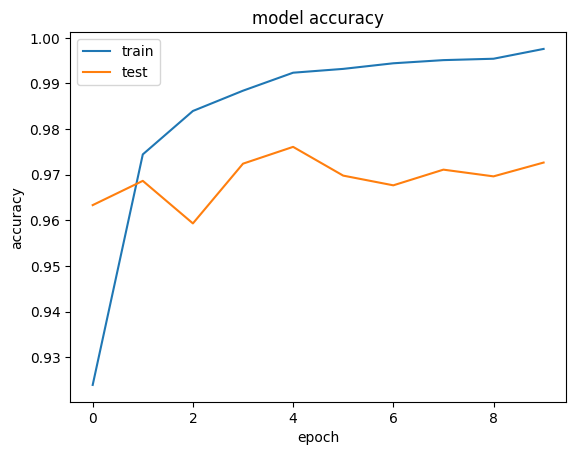

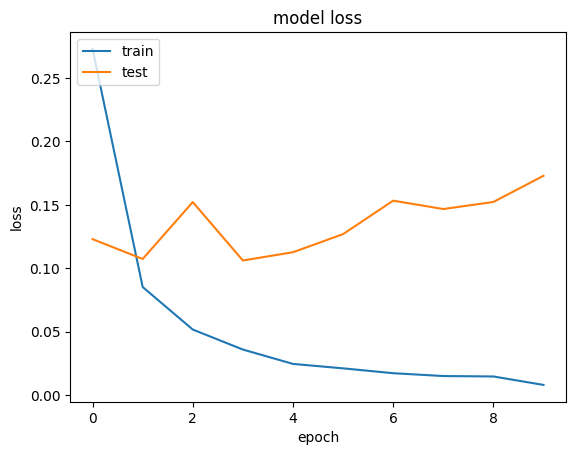

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)            

In [50]:
# Print the top 25%
print_top(X_sort, y_sort, is_last=True)
print_prediction(first_prediction, first_probability, second_prediction, second_probability, is_last=True)
show_history(history)
conv3.summary()

In [51]:
df_c3 = pd.DataFrame(cmatrix_c3, index=letters, columns=letters)
df_c3.style.background_gradient(cmap="hot_r")
df_c3

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
A,456,0,0,0,0,0,1,3,0,0,...,1,0,0,0,0,0,0,0,0,0
B,1,458,0,1,0,0,3,0,0,0,...,3,2,0,0,1,0,0,0,0,0
C,0,0,513,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,1,1,0,450,0,0,0,0,0,1,...,1,0,0,0,2,0,1,0,0,0
E,0,0,2,0,395,7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,443,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
G,0,0,3,0,0,0,440,0,0,0,...,2,0,0,0,0,0,0,0,0,0
H,4,0,0,0,0,0,0,372,1,0,...,0,0,0,0,1,0,0,1,0,0
I,0,0,0,0,0,2,1,0,654,2,...,0,0,0,0,0,0,0,0,0,1
J,0,0,0,1,0,1,1,0,6,462,...,0,0,2,0,1,2,0,1,0,0


In [52]:
# build the model
sgd_model = sgd_optimizer()
checkpoint = get_checkpoint('sgd')

# fit the model
history =  sgd_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, callbacks=[checkpoint, early], verbose=2)

Epoch 1/10


2022-09-03 11:07:48.907131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 11:09:42.649118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.89492, saving model to sgd.h5
693/693 - 120s - loss: 0.6824 - accuracy: 0.8119 - val_loss: 0.3720 - val_accuracy: 0.8949 - 120s/epoch - 173ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.89492 to 0.95122, saving model to sgd.h5
693/693 - 100s - loss: 0.2200 - accuracy: 0.9389 - val_loss: 0.1732 - val_accuracy: 0.9512 - 100s/epoch - 145ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.95122
693/693 - 101s - loss: 0.1404 - accuracy: 0.9602 - val_loss: 0.1863 - val_accuracy: 0.9455 - 101s/epoch - 146ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.95122 to 0.95409, saving model to sgd.h5
693/693 - 101s - loss: 0.1048 - accuracy: 0.9703 - val_loss: 0.1560 - val_accuracy: 0.9541 - 101s/epoch - 146ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.95409 to 0.96309, saving model to sgd.h5
693/693 - 101s - loss: 0.0834 - accuracy: 0.9767 - val_loss: 0.1316 - val_accuracy: 0.9631 - 101s/epoch - 146ms/step
Ep

382/382 [==============================] - 7s 18ms/step - loss: 0.1627 - accuracy: 0.9588
Accuracy: 0.9588346481323242 
 Error: 4.116535186767578
  9/382 [..............................] - ETA: 5s

2022-09-03 11:24:58.890724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 7s 17ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       464
           1       0.98      0.95      0.97       470
           2       0.97      0.98      0.98       520
           3       0.99      0.75      0.86       479
           4       0.93      0.99      0.96       405
           5       0.96      0.98      0.97       445
           6       0.96      0.97      0.96       445
           7       0.97      0.95      0.96       384
           8       0.97      0.99      0.98       664
           9       0.97      0.97      0.97       477
          10       0.97      0.96      0.96       459
          11       0.98      0.98      0.98       521
          12       0.99      0.96      0.97       471
          13       0.97      0.96      0.96       489
          14       0.81      0.99      0.89       478
          15       0.98      0.98      0.98       475
          16       0.96  

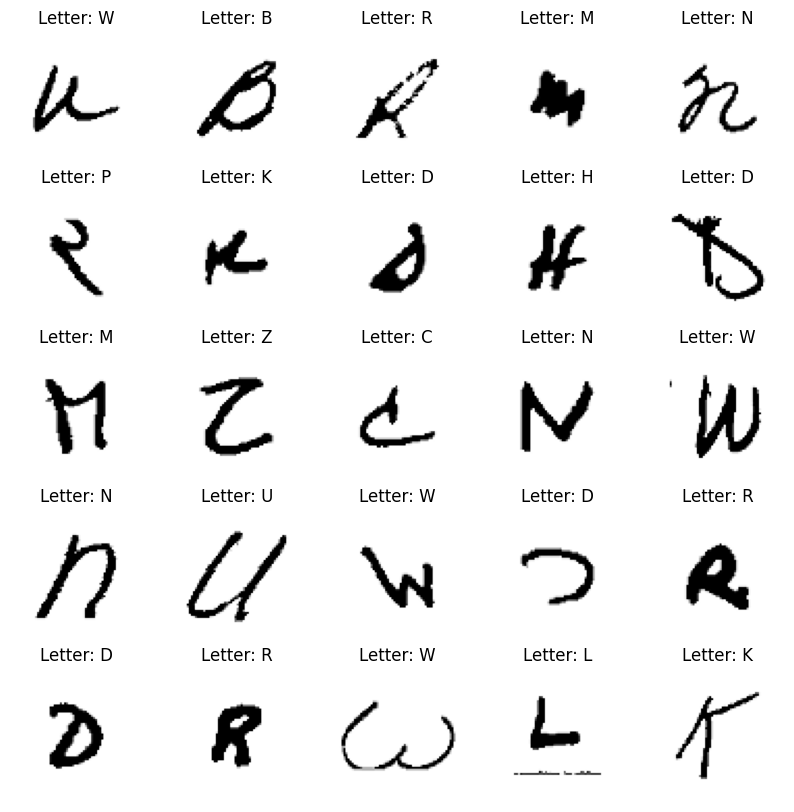

Index:  0  Prediction:  W ( 0.25744006 ) -  G ( 0.22258957 )
Index:  1  Prediction:  B ( 0.33087 ) -  O ( 0.32192937 )
Index:  2  Prediction:  K ( 0.33719507 ) -  H ( 0.21349698 )
Index:  3  Prediction:  U ( 0.34539825 ) -  A ( 0.23128337 )
Index:  4  Prediction:  U ( 0.3519977 ) -  A ( 0.24183704 )
Index:  5  Prediction:  P ( 0.352184 ) -  T ( 0.308296 )
Index:  6  Prediction:  G ( 0.35542047 ) -  K ( 0.2712608 )
Index:  7  Prediction:  W ( 0.35574415 ) -  I ( 0.26827148 )
Index:  8  Prediction:  K ( 0.37510914 ) -  X ( 0.37353855 )
Index:  9  Prediction:  D ( 0.3789029 ) -  B ( 0.3511858 )
Index:  10  Prediction:  N ( 0.38622358 ) -  M ( 0.35571897 )
Index:  11  Prediction:  C ( 0.38787302 ) -  Z ( 0.29118466 )
Index:  12  Prediction:  C ( 0.39622253 ) -  L ( 0.37429687 )
Index:  13  Prediction:  W ( 0.3971615 ) -  N ( 0.31257603 )
Index:  14  Prediction:  M ( 0.40038624 ) -  W ( 0.37252644 )
Index:  15  Prediction:  O ( 0.41004977 ) -  N ( 0.21245325 )
Index:  16  Prediction:  U ( 0

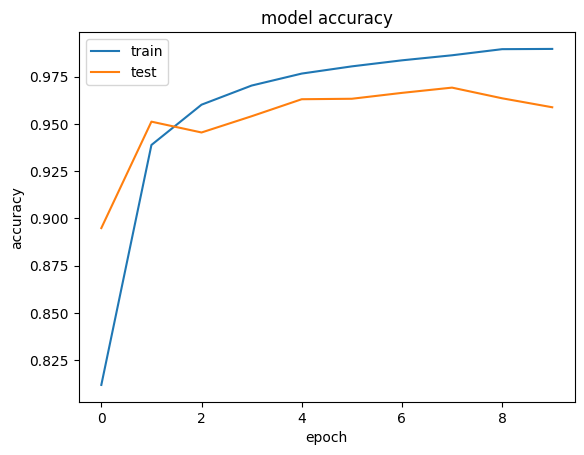

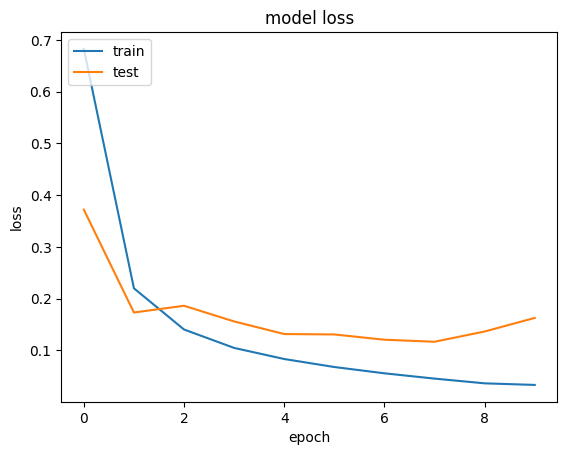

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 32768)            

In [53]:
# Make prediction and sort
sgd_predict, cmatrix_sgd = evaluate_and_predict(sgd_model)

indexes, first_prediction, first_probability, second_prediction, second_probability = sort_prediction(sgd_predict)
X_sort, y_sort = xy_sort(indexes)

# Print information
print_top(X_sort, y_sort)
print_prediction(first_prediction, first_probability, second_prediction, second_probability)
show_history(history)
sgd_model.summary()

In [54]:
df_sgd = pd.DataFrame(cmatrix_sgd, index=letters, columns=letters)
df_sgd.style.background_gradient(cmap="hot_r")

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
A,453,1,0,0,0,2,1,2,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0
B,0,446,0,0,10,1,3,0,0,0,0,0,0,0,3,0,1,2,1,0,0,0,0,1,0,2
C,0,0,508,0,2,0,5,0,0,0,0,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0
D,0,4,1,360,0,0,2,0,2,3,0,0,0,0,97,3,0,0,1,1,1,1,1,0,0,2
E,0,0,1,0,401,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,1,436,1,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,2
G,0,0,6,0,3,1,431,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0
H,4,0,0,0,0,0,1,364,1,1,3,1,2,3,0,0,0,0,0,0,2,1,0,0,1,0
I,0,0,0,0,0,1,1,0,655,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2
J,0,0,0,0,0,0,1,0,6,461,0,0,0,0,1,0,0,0,6,1,0,1,0,0,0,0
